In [1]:
import pandas as pd
import StringIO
import requests
import zipfile
import os
import geopandas as gpd
import matplotlib.pylab as plt
%pylab inline
import sklearn.cluster as cluster
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch
from sklearn.cluster import DBSCAN

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


### Import Census Data

In [2]:
year = [i for i in range(1994, 2015)]
abreev = ['94', '95', '96', '97', '98', '99', '00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14']

In [3]:
#download census data
#no data for 1993
#http://www2.census.gov/programs-surveys/cbp/datasets/1994/zbp94totals.zip
zbps = []
for i in range(0,21):
    #r = requests.get("http://www2.census.gov/programs-surveys/cbp/datasets/" + str(year[i]) + "/zbp" + abreev[i] + "totals.zip") 
    #z = zipfile.ZipFile(StringIO.StringIO(r.content))
    #citi_csv = z.extractall("/Users/kristikorsberg/devel/PUI/")
    name = 'zbps' + str(year[i])
    name = pd.read_csv("/Users/kristikorsberg/devel/PUI/zbp" + abreev[i] + "totals.txt", sep=",")
    #name = name.ix[1:]
    zbps.append(name)

In [4]:
#check zbps data for null values
for i in range(0,21):
    print(zbps[i].isnull().sum())

zip            0
name           0
empflag    32622
emp            0
qp1            0
ap             0
est            0
dtype: int64
zip            0
name           0
empflag    34074
emp            0
qp1            0
ap             0
est            0
dtype: int64
zip            0
name           0
empflag    34930
emp            0
qp1            0
ap             0
est            0
dtype: int64
zip            0
name           0
empflag    34802
emp            0
qp1            0
ap             0
est            0
dtype: int64
ZIP            0
NAME           0
EMPFLAG    33697
EMP            0
QP1            0
AP             0
EST            0
dtype: int64
ZIP            0
NAME           0
EMPFLAG    34362
EMP            0
QP1            0
AP             0
EST            0
dtype: int64
ZIP            0
NAME           0
EMPFLAG    34276
EMP            0
QP1            0
AP             0
EST            0
dtype: int64
ZIP            0
NAME           0
EMPFLAG    34344
EMP            0
QP1     

In [5]:
#check column headers for all 20 years
for i in range(0,21):
    print(zbps[i].head())

    zip         name empflag   emp    qp1      ap  est
0  1001   Agawam, MA     NaN  6198  33601  155158  439
1  1002  Amherst, MA     NaN  6073  28924  127367  450
2  1003  Amherst, MA     NaN    68    367    1604   10
3  1004  Amherst, MA     NaN   210    844    4302   47
4  1005    Barre, MA     NaN   678   3010   13521   92
    zip             name empflag   emp    qp1      ap  est
0   501   Holtsville, NY       B     0      0       0    2
1  1000  Springfield, MA     NaN    49    529    2127    4
2  1001       Agawam, MA     NaN  5920  32993  152512  439
3  1002      Amherst, MA     NaN  6153  31645  132699  467
4  1003      Amherst, MA     NaN    89    380    1698   10
    zip             name empflag   emp    qp1      ap  est
0   501   Holtsville, NY       B     0      0       0    4
1  1000  Springfield, MA     NaN   161   1494    6671   11
2  1001       Agawam, MA     NaN  6130  37746  171045  433
3  1002      Amherst, MA     NaN  6441  32964  141756  487
4  1003      Amherst,

### Drop Unnecessary Census Data Columns

In [6]:
#drop oolumns except zip code and number of establishments
for i in range(4,9):
    est = 'est' + str(year[i])
    zbps[i] = zbps[i][['ZIP', 'EST']]
    zbps[i] = zbps[i].rename(columns={'ZIP':'zip', 'EST':est})

In [7]:
for i in range(0,4):
    est = 'est' + str(year[i])
    zbps[i] = zbps[i][['zip', 'est']]
    zbps[i] = zbps[i].rename(columns={'est':est})

In [8]:
for i in range(9,21):
    est = 'est' + str(year[i])
    zbps[i] = zbps[i][['zip', 'est']]
    zbps[i] = zbps[i].rename(columns={'est':est})

In [9]:
#merge separate census DFs to one 
t = pd.merge(zbps[0], zbps[1], on='zip', how='outer')
for i in range(2,21):
    t = pd.merge(t, zbps[i], on='zip', how='outer')

In [10]:
t.head()

,zip,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,...,est2005,est2006,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014
0,1001,439.0,439.0,433.0,457.0,444.0,469.0,493.0,490.0,490.0,...,509.0,509.0,503.0,477.0,458.0,448.0,436.0,453.0,439.0,458.0
1,1002,450.0,467.0,487.0,500.0,490.0,558.0,563.0,587.0,566.0,...,589.0,582.0,596.0,584.0,571.0,570.0,558.0,572.0,572.0,560.0
2,1003,10.0,10.0,13.0,15.0,14.0,13.0,13.0,13.0,15.0,...,12.0,12.0,16.0,17.0,16.0,16.0,16.0,15.0,15.0,18.0
3,1004,47.0,48.0,47.0,41.0,31.0,35.0,48.0,37.0,23.0,...,31.0,30.0,20.0,18.0,18.0,21.0,19.0,16.0,16.0,13.0
4,1005,92.0,95.0,101.0,104.0,95.0,82.0,86.0,90.0,94.0,...,94.0,98.0,106.0,97.0,87.0,96.0,91.0,94.0,97.0,97.0


In [11]:
t['zip'].dtype

dtype('int64')

### Import Zip Code Geometries

In [12]:
#download zip code geojson
zips = gpd.read_file("nyc-zip-code-tabulation-areas-polygons.geojson")
zips.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [13]:
print(len(zips))
zips['postalCode'] = zips['postalCode'].astype(int)
zips['postalCode'].dtype

262


dtype('int64')

### Merge Geometry Data and Census Data on NYC Zip Code Names

In [14]:
#merge t and zips on 'zips' to keep only NYC zip codes
zips = pd.merge(t, zips, left_on='zip', right_on='postalCode', how='right')

In [15]:
zips = zips.drop(['zip', '@id', 'BLDGpostalCode', 'CTY_FIPS', 'OBJECTID', 'PO_NAME', 'STATE', 'ST_FIPS', 'Shape_Area', 'Shape_Leng', 'borough'], axis=1)

In [16]:
zips.head()

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014,geometry,postalCode
0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0,POLYGON ((-74.00827017711134 40.75258714368449...,10001
1,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0,POLYGON ((-73.97441674489379 40.73642441865476...,10002
2,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0,POLYGON ((-73.97986374196766 40.73497446573838...,10003
3,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,"POLYGON ((-74.00596661578348 40.7043243225291,...",10004
4,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,POLYGON ((-74.04166368343016 40.69644987183209...,10004


In [17]:
#check for null values
zips.isnull().sum()

est1994        7
est1995       11
est1996       10
est1997       10
est1998       10
est1999       13
est2000        9
est2001        9
est2002       10
est2003       10
est2004       11
est2005        8
est2006        7
est2007        6
est2008        9
est2009        9
est2010        8
est2011        9
est2012       11
est2013       11
est2014       12
geometry       0
postalCode     0
dtype: int64

In [18]:
zips = zips.drop_duplicates(['postalCode'])

In [19]:
zips = zips.dropna()

In [20]:
zb = zips

In [21]:
zb.crs = {'init' :'epsg:4326'}
zb = zb.reset_index()
zb = zb.drop('index', axis=1)
zb.head()

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014,geometry,postalCode
0,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0,POLYGON ((-74.00827017711134 40.75258714368449...,10001
1,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0,POLYGON ((-73.97441674489379 40.73642441865476...,10002
2,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0,POLYGON ((-73.97986374196766 40.73497446573838...,10003
3,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0,"POLYGON ((-74.00596661578348 40.7043243225291,...",10004
4,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0,"POLYGON ((-74.00596661578348 40.7043243225291,...",10005


In [22]:
z = zb.drop(['geometry', 'postalCode'], axis=1)
z = z.astype(int)
zbm = z.as_matrix()

### Visualize Time Series Data

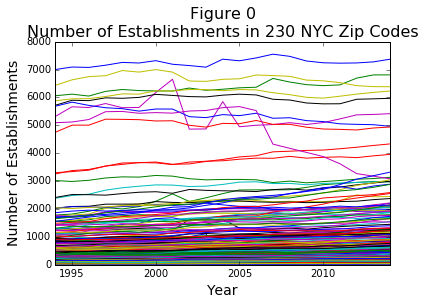

In [23]:
## plt.figure(figsize(10,8))
x = [i for i in year]
for k in range(0,230):
    plt.plot(x, zbm[k], ls='solid')
plt.xlim(1994, 2014)
plt.title('Figure 0\nNumber of Establishments in 230 NYC Zip Codes', fontsize=16)
plt.ylabel('Number of Establishments', fontsize=14)
plt.xlabel('Year', fontsize=14)

#### Caption for Figure 0
Figure 0 is a line graph of the volume of business establishment trends between 1994 and 2014 in New York City. 

In [24]:
z.head()

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2005,est2006,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014
0,6999,7088,7075,7154,7254,7233,7317,7188,7141,7084,...,7312,7415,7549,7472,7305,7241,7227,7235,7273,7369
1,1784,1819,1919,2049,2003,2085,2277,2543,2269,2402,...,2682,2686,2685,2691,2775,2872,2912,2954,2988,2972
2,3256,3377,3417,3535,3649,3659,3683,3602,3616,3704,...,3867,3909,4049,4071,4099,4113,4159,4214,4277,4333
3,1115,1124,1133,1173,1176,1233,1294,1247,1253,1252,...,1260,1311,1370,1376,1379,1398,1404,1442,1479,1554
4,1076,1109,1216,1227,1270,1242,1287,1249,1244,1200,...,1214,1259,1273,1291,1274,1266,1301,1273,1296,1321


### Standardize the Data

In [25]:
z = z.T

In [26]:
#standardize data
z_stand = (z - z.mean()) / z.std()
z_stand.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
est1994,-1.839191,-1.713540,-1.820497,-1.512649,-2.819347,1.576901,-0.444220,-1.695218,-0.589198,-2.146355,...,-2.114934,-1.632651,-1.405005,-1.296083,-1.134733,-0.805023,-0.947361,-0.458450,-0.842815,-1.541458
est1995,-1.193297,-1.626405,-1.434653,-1.438217,-2.263972,0.902719,-0.717132,-1.700614,-1.026701,-1.938151,...,-1.587098,-1.514780,-1.286312,-1.347340,-1.134733,-0.967353,-0.854828,-0.710477,-1.375564,-1.716434
est1996,-1.287641,-1.377447,-1.307101,-1.363786,-0.463213,0.525634,-0.882533,-1.484761,-0.452478,-1.660546,...,-1.549396,-1.382175,-1.306094,-1.193568,-1.134733,-0.689073,-0.484696,-0.811288,-1.257175,-1.366482
est1997,-0.714319,-1.053802,-0.930824,-1.032980,-0.278088,0.765597,-0.609621,-1.085433,0.682297,-0.865101,...,-1.134668,-0.792821,-1.276421,-1.296083,-0.218218,-0.851403,-0.299630,-1.063315,-0.842815,-0.666576
est1998,0.011404,-1.168323,-0.567301,-1.008170,0.445582,1.222670,-0.650971,-0.874976,1.229177,-0.555464,...,-0.493724,-1.043297,-0.930233,-1.296083,-0.218218,-1.129683,-0.669762,-1.264937,-1.020398,-0.666576


In [27]:
#z_stand.std()

In [28]:
#print(z_stand.mean())

In [29]:
#n_zipcodes x n_timestamps
z_stand = z_stand.T
zbm_stand = z_stand.as_matrix()
zbm_stand.shape

(230, 21)

### Visualization of Standardized Data

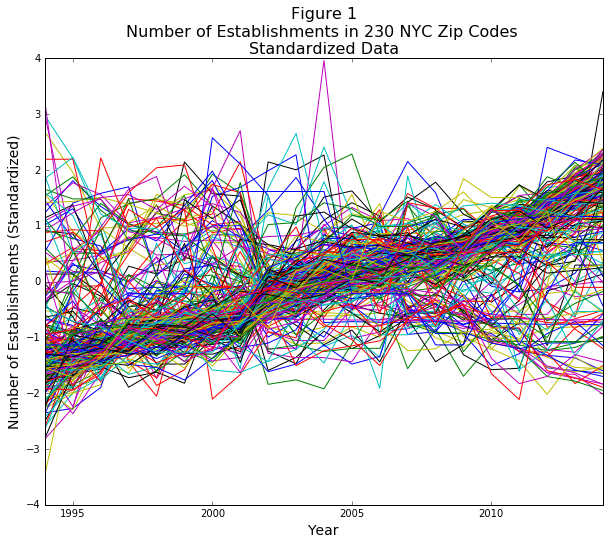

In [30]:
plt.figure(figsize(10,8))
x = [i for i in year]
for k in range(0,230):
    plt.plot(x, zbm_stand[k], ls='solid')
plt.xlim(1994, 2014)
plt.title('Figure 1\nNumber of Establishments in 230 NYC Zip Codes \nStandardized Data', fontsize=16)
plt.ylabel('Number of Establishments (Standardized)', fontsize=14)
plt.xlabel('Year', fontsize=14)

#### Caption for Figure 1
Figure 1 is a time series plot of the number of established businesses in each New York City zip code from 1994 through 2014. Each line represents a distinct zip code, with the heigh of each line representing the number of establishments.

### Cluster Time Series with KMeans and Plot

In [31]:
n = 5
KM=cluster.KMeans(n_clusters=n, random_state=123)# cluster=5
KM.fit(zbm_stand)
zbm_stand_KM=KM.predict(zbm_stand)
centers=KM.cluster_centers_

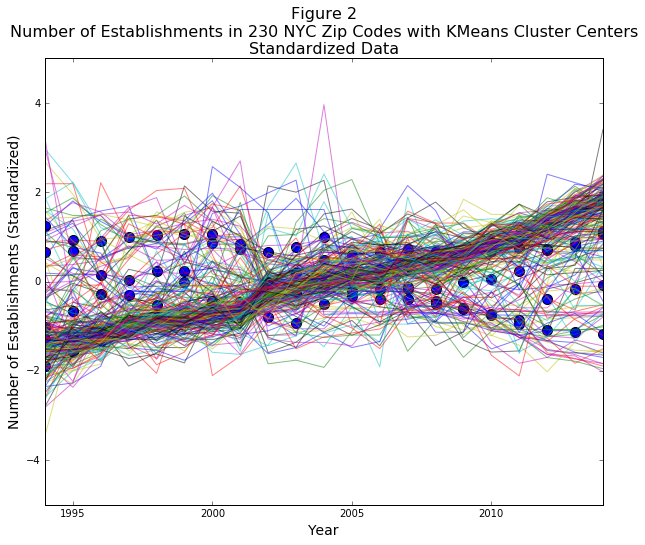

In [51]:
x = [i for i in year]
for k in range(0,230):
    plt.plot(x, zbm_stand[k], ls='solid', alpha=.5)
for i in range(0,21):
    for k in range(0,5):
        plt.scatter(x[i], centers[k][i], s=100)
plt.xlim(1994,2014)
plt.ylim(-5,5)
plt.title('Figure 2\nNumber of Establishments in 230 NYC Zip Codes with KMeans Cluster Centers\nStandardized Data', fontsize=16)
plt.ylabel('Number of Establishments (Standardized)', fontsize=14)
plt.xlabel('Year', fontsize=14)

#### Caption for Figure 2
Figure 2 is a time series plot of the number of established businesses in each New York City zip code from 1994 through 2014. Each line represents a distinct zip code, with the height of each line, now standardized, representing the number of establishments. Figure 2 also includes scatter plotted cluster means for each of the five KMeans clusters, created after running the algorithm. There is a cluster center for each cluster for each year.

In [33]:
z_stand_clust = z_stand
z_stand_clust['cluster'] = KM.labels_

In [34]:
z_stand_clust.head()

,est1994,est1995,est1996,est1997,est1998,est1999,est2000,est2001,est2002,est2003,...,est2006,est2007,est2008,est2009,est2010,est2011,est2012,est2013,est2014,cluster
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,1
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,1
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,4
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,4
4,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,1


In [35]:
zero = z_stand_clust.loc[z_stand_clust['cluster'] == 0]
zero = zero.iloc[:,:21].as_matrix()
print(zero.shape)

(19, 21)


In [36]:
one = z_stand_clust.loc[z_stand_clust['cluster'] == 1]
one = one.iloc[:,:21].as_matrix()
print(one.shape)

(47, 21)


In [37]:
two = z_stand_clust.loc[z_stand_clust['cluster'] == 2]
two = two.iloc[:,:21].as_matrix()
print(two.shape)

(16, 21)


In [38]:
three = z_stand_clust.loc[z_stand_clust['cluster'] == 3]
three = three.iloc[:,:21].as_matrix()
print(three.shape)

(25, 21)


In [39]:
four = z_stand_clust.loc[z_stand_clust['cluster'] == 4]
four = four.iloc[:,:21].as_matrix()
print(four.shape)

(123, 21)


(1994, 2014)

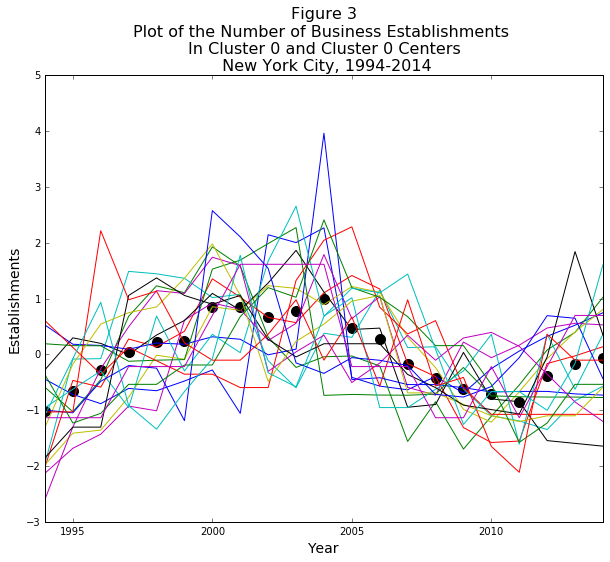

In [40]:
x = [i for i in year]
for k in range(0,19):
    plt.plot(x, zero[k], ls='solid')
for i in range(0,21):
    plt.scatter(x[i], centers[0][i], c='k', s=100)
plt.title('Figure 3\nPlot of the Number of Business Establishments \nIn Cluster 0 and Cluster 0 Centers\n New York City, 1994-2014', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Establishments', fontsize=14)
plt.xlim(1994,2014)
#plt.legend(loc='best')

(1994, 2014)

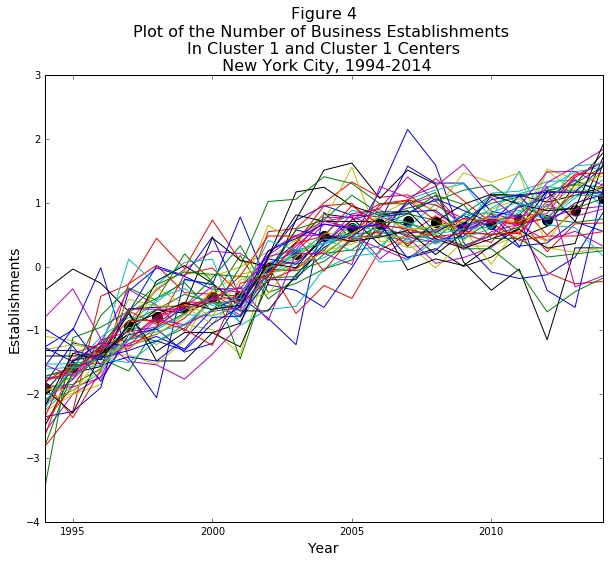

In [41]:
for k in range(0,47):
    plt.plot(x, one[k], ls='solid')
for i in range(0,21):
    plt.scatter(x[i], centers[1][i], c='k', s=100)
plt.title('Figure 4\nPlot of the Number of Business Establishments \nIn Cluster 1 and Cluster 1 Centers\n New York City, 1994-2014', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Establishments', fontsize=14)
plt.xlim(1994,2014)
#plt.legend(loc='best')

(1994, 2014)

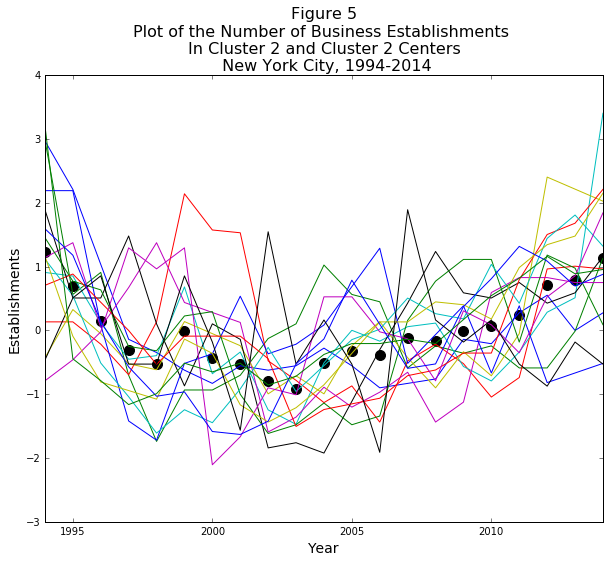

In [42]:
for k in range(0,16):
    plt.plot(x, two[k], ls='solid')
for i in range(0,21):
    plt.scatter(x[i], centers[2][i], c='k', s=100)
plt.title('Figure 5\nPlot of the Number of Business Establishments \nIn Cluster 2 and Cluster 2 Centers\n New York City, 1994-2014', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Establishments', fontsize=14)
plt.xlim(1994,2014)
#plt.legend(loc='best')

(1994, 2014)

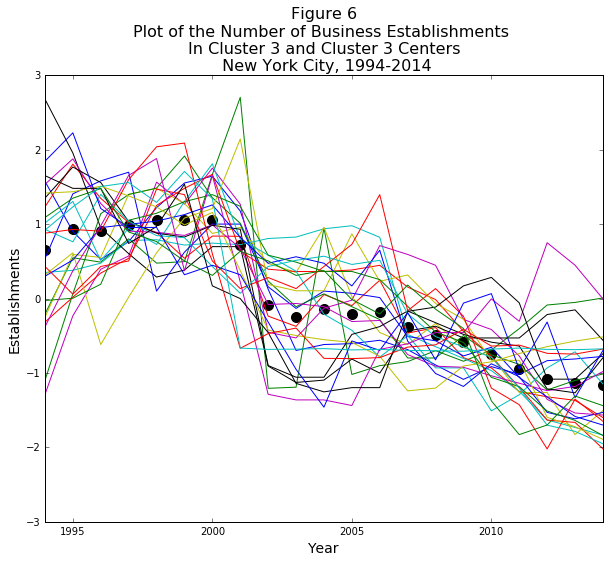

In [43]:
for k in range(0,25):
    plt.plot(x, three[k], ls='solid')
for i in range(0,21):
    plt.scatter(x[i], centers[3][i], c='k', s=100)
plt.title('Figure 6\nPlot of the Number of Business Establishments \nIn Cluster 3 and Cluster 3 Centers\n New York City, 1994-2014', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Establishments', fontsize=14)
plt.xlim(1994,2014)
#plt.legend(loc='best')

(-2.5, 3)

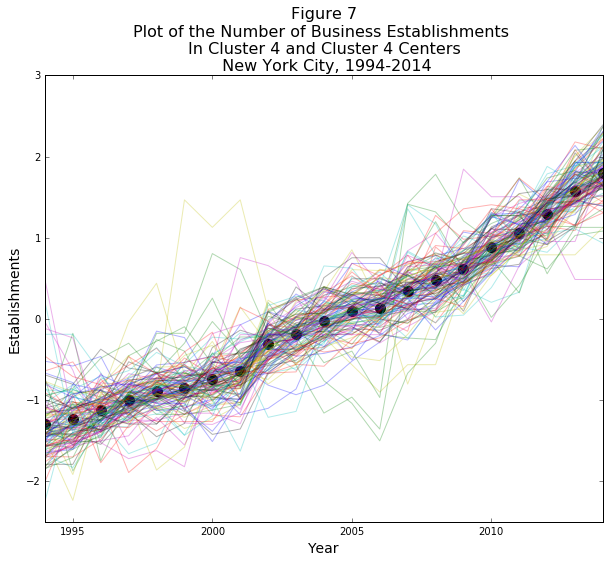

In [44]:
for k in range(0,123):
    plt.plot(x, four[k], ls='solid', alpha=.3)
for i in range(0,21):
    plt.scatter(x[i], centers[4][i], c='k', s=100)
plt.title('Figure 7\nPlot of the Number of Business Establishments \nIn Cluster 4 and Cluster 4 Centers\n New York City, 1994-2014', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Establishments', fontsize=14)
plt.xlim(1994,2014)
plt.ylim(-2.5,3)

#### Caption for Figures 3 - 7
Figures 3 through 7 are distinct plots, with information from each of the five KMeans clusters. The black scattered plot represents the cluster mean for each year while the lines represent the standardized volume of business establishments in each of the clustered zip codes. With KMeans clustering, cluster 0 had 76 zip codes, cluster 1 had 9, cluster 2 had 105, cluster 3 had 12, and cluster 4 had 28. 

### Cluster and Plot with DBSCAN

In [45]:
#sklearn.cluster.DBSCAN(eps=0.5, min_samples=5, metric='euclidean', algorithm='auto', leaf_size=30, p=None, n_jobs=1)
#eps = maximum distance between two points, which can be considered the same cluster
#min_samples = # of samples, or total weight in a neighborhood for a point to be considered a core point
#metric = 
#algorithm = the algorithm used to compute pairwise nearest neighbor distances 
#leaf size = 
#p = the power of the Minkowski metric to be used to calculate the distance between points
#n_jobs = 

In [46]:
zb2 = zbm_stand

In [67]:
z.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
est1994,6999,1784,3256,1115,1076,1061,1307,634,3019,3301,...,226,760,586,51,2,401,66,95,294,33
est1995,7088,1819,3377,1124,1109,1002,1274,633,2987,3340,...,240,768,598,50,2,394,67,90,285,32
est1996,7075,1919,3417,1133,1216,969,1254,673,3029,3392,...,241,777,596,53,2,406,71,88,287,34
est1997,7154,2049,3535,1173,1227,990,1287,747,3112,3541,...,252,817,599,51,3,399,73,83,294,38
est1998,7254,2003,3649,1176,1270,1030,1282,786,3152,3599,...,269,800,634,51,3,387,69,79,291,38


In [86]:
#http://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py
db = DBSCAN(eps=2, min_samples=5).fit(zbm_stand)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [87]:
print(labels)

[-1  0  0  0 -1 -1 -1  0 -1  0  0 -1  0 -1 -1  0 -1 -1  1 -1  0  0  0  0  0
  0  0  0  0  0  0  0  0 -1  0 -1  0  0  0 -1  0 -1 -1 -1  1 -1 -1 -1 -1 -1
 -1 -1 -1  1  0 -1 -1 -1 -1  0 -1  1 -1 -1 -1 -1 -1  1 -1  0 -1  1 -1  0 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0  0  0  0  0  0  0  0  0  0 -1
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0 -1 -1  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0
  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0 -1  0  0  0 -1  0  0  0  0  0 -1
  0 -1  0  0 -1]


In [88]:
#number of clusters in labels, ignoring noise if present
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print(n_clusters_)

2


In [90]:
zb_stand_dbscan.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,cluster
0,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,-1
1,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0
2,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0
3,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0
4,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,-1


In [91]:
zb_stand_dbscan = pd.DataFrame(zbm_stand)
zb_stand_dbscan['geometry'] = zb['geometry']
zb_stand_dbscan['postalCode'] = zb['postalCode']
zb_stand_dbscan['cluster'] = labels
zb_stand_dbscan = zb_stand_dbscan.set_geometry('geometry')

/Users/kristikorsberg/devel/venv/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


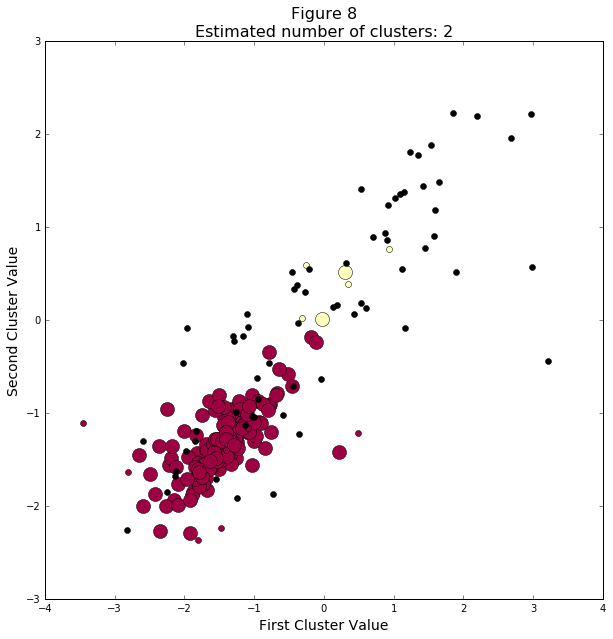

In [92]:
plt.figure(figsize=(10,10))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = zbm_stand[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)

    xy = zbm_stand[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=6)

plt.title('Figure 8\nEstimated number of clusters: %d' % n_clusters_, fontsize=16)
plt.xlabel('First Cluster Value', fontsize=14)
plt.ylabel('Second Cluster Value', fontsize=14)
plt.show()

### Plot Zip Code Clusters on Map of New York City

In [94]:
zbm_stand[1]

array([-1.71354039, -1.62640519, -1.37744747, -1.05380244, -1.16832299,
       -0.96417767, -0.48617885,  0.17604867, -0.50609547, -0.17498171,
        0.19596529,  0.52209989,  0.5320582 ,  0.52956863,  0.54450609,
        0.75363057,  0.99511955,  1.09470264,  1.19926488,  1.2839105 ,
        1.24407727])

In [95]:
z_stand_clust = z_stand_clust.reset_index()
z_stand_clust = z_stand_clust.drop('index', axis=1)
z_stand_clust['geometry'] = zb['geometry']
z_stand_clust['zip'] = zb['postalCode']

In [96]:
z_stand_clust = z_stand_clust.set_geometry('geometry')

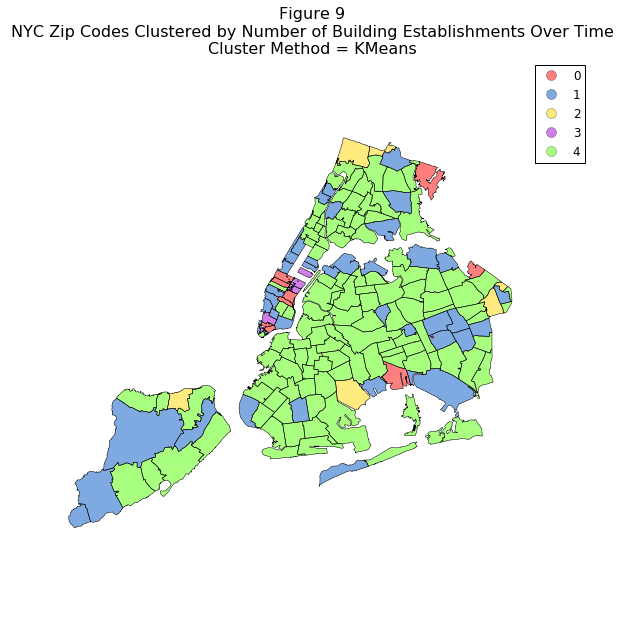

In [97]:
#kmeans map
#http://matplotlib.org/examples/color/colormaps_reference.html
#got assistance with plotting from hw10 plot
f, ax = plt.subplots(figsize=(10,10))
z_stand_clust.assign(cl=z_stand_clust['cluster']).plot(column='cluster', categorical=True, 
        cmap='prism', linewidth=0.5, ax=ax, 
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title('Figure 9\nNYC Zip Codes Clustered by Number of Building Establishments Over Time\nCluster Method = KMeans', fontsize=16)

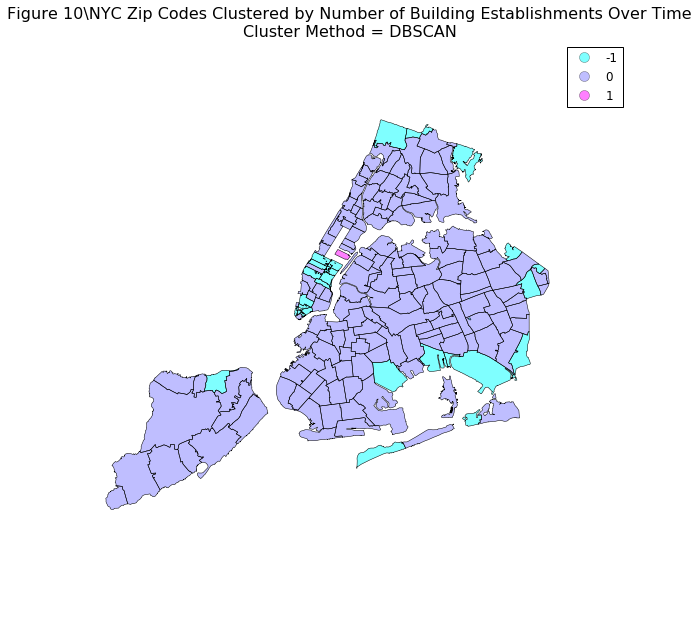

In [98]:
#DBSCAN map
#-1 = outlier
f, ax = plt.subplots(figsize=(10,10))
zb_stand_dbscan.assign(cl=zb_stand_dbscan['cluster']).plot(column='cluster', categorical=True, 
        cmap='cool', linewidth=0.5, ax=ax, 
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.title('Figure 10\NYC Zip Codes Clustered by Number of Building Establishments Over Time\nCluster Method = DBSCAN', fontsize=16)

#### Caption for Figures 9 and 10
Figures 9 and 10 are a visual representation of the clustered zip codes, first by KMeans clustering and second by DBSCAN. For KMeans, I selected five clusters, while the DBSCAN algorithm created two clusters and one group of outliers. In figure 10, the outliers, which didn't belong to either identified cluster, are equal to the '-1' value, or the light blue colored zip codes.

#### Compare the Clustering Results
The KMeans and DBSCAN clustering methods yielded very different results. 
I chose DBSCAN as the secondary clustering method because of the time series data's high density structure, seen in Figures 0-2. I thought this clustering method would perform a different analysis than KMeans, since it finds core samples of high density and expands clusters from them (sklearn website). The primary differences between KMeans and DBSCAN is in the consideration of density and in the method through which clusters are defined. From a density and distance perspective, DBSCAN only identified two separate clusters. Density may be important to consider here because KMeans could be separating zip codes simply because it has to generate a certain number of groups, when, in reality, the differences between the densely compacted groups is not great. The DBSCAN analysis is curious because considered most zip codes in Manhattan to be outliers. 

#### Clustering and Map Interpretation
After cleaning the data, I had 230 zip codes without any null values. These were the zip codes through which I conducted my analysis. KMeans is a clustering method which reduces the sum of the distances of the data points to their respectively assigned centroids. In this case, the zip codes grouped together have similar growth or change patterns, indicating that the clustering algorithm considered not just each zip code in one year, but each zip code over 20 years. Each KMeans cluster is a different size. Because I have clustered the zip codes with just one attribute, the number of business establishments over 20 years, I can really only conclude that the the zip codes are clustered together due to a similarity in volume and change in volume of this one attribute. 

It's not surprising that the zip codes in midtown Manhattan are clustered together and are distinct from all other groups, since traditionally, this is the heart of commercial activity in New York City. Eastern and southern Brooklyn as well as Upper Manhattan, all of Queens, and Staten Island have similarities, in that only clusters zero, two, and four are represented. Lower Manhattan and eastern Brooklyn are clustered together in group three. 

With more research, I would hypothesize that these clusters would reflect gentrification and commercial growth patterns (timing, volume, and rate) across the five boroughs in the past 20 years. 